<a href="https://colab.research.google.com/github/royam0820/fastai2-v4/blob/master/GPT2_LM_FR_allocine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OpenAI GPT2 model Infos
[Model Info](https://huggingface.co/transformers/model_doc/gpt2.html)

[The Illustrated GPT-2 (Visualizing Transformer Language Models)](http://jalammar.github.io/illustrated-gpt2/#model-output)

GPT-2 is a large transformer-based language model with **1.5 billion parameters**, trained on a dataset of 8 million web pages. GPT-2 is trained with a simple objective: predict the next word, given all of the previous words within some text. 

 


# Infos Notebook

This notebook is used to fine-tune GPT2 model for text classification using Huggingface transformers library on a custom dataset.

For the dataset, we are using the French AlloCine reviews, which are French reviews on films. 

Main idea: is to use a GPT2 model that has been pretrained with French texts, and then fine-tune this language model on a sub-domain which are the French reviews from AlloCine website.


In [1]:
# !nvidia-smi

In [2]:
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

     |████████████████████████████████| 204kB 10.1MB/s 
     |████████████████████████████████| 61kB 6.9MB/s 


In [3]:
!pip install -Uq transformers
from fastai.text.all import *

     |████████████████████████████████| 2.3MB 11.8MB/s 
     |████████████████████████████████| 901kB 36.1MB/s 
     |████████████████████████████████| 3.3MB 36.0MB/s 


In [4]:
# # better display of review text in dataframes
# pd.set_option('display.max_colwidth', None) 

# BelGPT-2 - a GPT-2 model pre-trained on French corpora
This language model has been trained on French texts from different sources: Wikipedia, news, EuroParl texts. Its size is 60Gb.

https://github.com/antoiloui/belgpt2/blob/master/docs/index.md

https://huggingface.co/antoiloui/belgpt2



In [5]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [6]:
# Load pretrained model and tokenizer
model = GPT2LMHeadModel.from_pretrained("antoiloui/belgpt2")
tokenizer = GPT2Tokenizer.from_pretrained("antoiloui/belgpt2")
#tokenizer = ByteLevelBPETokenizer()

In [7]:
len(tokenizer.get_vocab())

50257

In [8]:
vocab_items = tokenizer.encoder.items() #dictionary

In [9]:
list(vocab_items)[:10]

[('<s>', 0),
 ('<pad>', 1),
 ('</s>', 2),
 ('!', 3),
 ('"', 4),
 ('#', 5),
 ('$', 6),
 ('%', 7),
 ('&', 8),
 ("'", 9)]

In [10]:
# getting the vocab in a list
vocab_lm = list(tokenizer.encoder.keys())
assert(len(vocab_lm) == tokenizer.vocab_size) # it returns True!

## Testing the Pretrained French Language Model

In [11]:
# encoding
ids = tokenizer.encode("c'est une histoire abracadabrantesque")
ids

[69, 9, 319, 338, 1396, 703, 7387, 631, 420, 22821, 345]

In [12]:
# decoding
tokenizer.decode(ids)

"c'est une histoire abracadabrantesque"

The model can be used to generate predictions (it is pretrained). It has a generate method that expects a batch of prompt, so we feed it our ids and add one batch dimension (there is a padding warning we can ignore as well)

In [13]:
t = torch.LongTensor(ids)[None]
preds = model.generate(t)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [14]:
preds.shape,preds[0]

(torch.Size([1, 20]),
 tensor([   69,     9,   319,   338,  1396,   703,  7387,   631,   420, 22821,
           345,   270,   369,   385,  8746,   364,   292,   941,  8670,   270]))

In [15]:
tokenizer.decode(preds[0].numpy())

"c'est une histoire abracadabrantesque, qui se déroule dans un monde parallèle,"

## Fine-Tuning the model

### Allocine Dataset

In [16]:
#creating a directory allocine
path = Path('/content/allocine/')
path.mkdir(parents=True, exist_ok=True)

In [17]:
#creating a directory allocine
path = Path('/content/allocine/models')
path.mkdir(parents=True, exist_ok=True)

In [18]:
path = Path('/content/allocine/'); path

Path('/content/allocine')

In [19]:
# downloading the AlloCine dataset
!wget -q https://github.com/TheophileBlard/french-sentiment-analysis-with-bert/raw/master/allocine_dataset/data.tar.bz2
!tar -xf /content/data.tar.bz2 -C '/content/allocine'

In [20]:
train_df = pd.read_json(path/'data/train.jsonl', lines=True, nrows=10000)
train_df.head(1)

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-135259/critiques/spectateurs,"Si vous cherchez du cinéma abrutissant à tous les étages,n'ayant aucune peur du cliché en castagnettes et moralement douteux,""From Paris with love"" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l'on se dirige vers la banlieue,on y trouve tout plein d'intégristes musulmans prêts à faire sauter le caisson d'une ambassadrice américaine.Nauséeux.Alors on se dit qu'on va au moins pouvoir apprécier la déconnade d'un classique buddy-movie avec le jeun...",0


In [21]:
val_df = pd.read_json(path/'data/val.jsonl', lines=True, nrows=1000)
val_df.head(1)

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-51895/critiques/spectateurs,"Ce film est tout ce qu'il y a de plus sympa. Même si l'ensemble n'est pas dépourvu de clichés, il serait hypocrite de dire que ce film est ennuyeux à regarder, bien au contraire. Il est très plaisant à regarder et même si l'ensemble est asse convenue, la mise en scène de Peter Chelsom est légère et ce film est une sorte de bouffée d'air frais. Tout à fait estimable.",0


In [22]:
train_df.to_csv(path/'data/train.csv', encoding = 'utf-8', header = False, index = False)

In [23]:
val_df.to_csv(path/'data/val.csv', encoding = 'utf-8', header = False, index = False)

In [ ]:
# !cp {path}/data/train.csv /content/drive/MyDrive/movie_fr_train.csv

In [ ]:
# !cp {path}/data/val.csv /content/drive/MyDrive/movie_fr_valid.csv

In [26]:
# training dataset
df_train = pd.read_csv(path/'data/train.csv', encoding = 'utf-8', header=None)
df_train.head(2)

,0,1,2
0,http://www.allocine.fr/film/fichefilm-135259/critiques/spectateurs,"Si vous cherchez du cinéma abrutissant à tous les étages,n'ayant aucune peur du cliché en castagnettes et moralement douteux,""From Paris with love"" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l'on se dirige vers la banlieue,on y trouve tout plein d'intégristes musulmans prêts à faire sauter le caisson d'une ambassadrice américaine.Nauséeux.Alors on se dit qu'on va au moins pouvoir apprécier la déconnade d'un classique buddy-movie avec le jeun...",0
1,http://www.allocine.fr/film/fichefilm-172430/critiques/spectateurs,"Trash, re-trash et re-re-trash...! Une horreur sans nom. Imaginez-vous les 20 premières minutes de Orange Mécanique dilatées sur plus de 70 minutes de bande VHS pourrave et revisitées par Korine à la sauce années 2000 : les dandys-punk de Kubrick ont laissé place à des papys lubriques déguisés en sacs-poubelles forniquant les troncs d'arbres, le dispositif esthétique se résume à du filmage-réalité enfilant des scènes de destruction, de soumission, de pornographie ou encore de maltraitance ( youtube, youtube et re-youtube...) et la bande-son se limite à des ricanements malades, des rengaine...",0


In [27]:
# validation dataset
df_valid = pd.read_csv(path/'data/val.csv', encoding = 'utf-8', header=None)
df_valid.head(2)

,0,1,2
0,http://www.allocine.fr/film/fichefilm-51895/critiques/spectateurs,"Ce film est tout ce qu'il y a de plus sympa. Même si l'ensemble n'est pas dépourvu de clichés, il serait hypocrite de dire que ce film est ennuyeux à regarder, bien au contraire. Il est très plaisant à regarder et même si l'ensemble est asse convenue, la mise en scène de Peter Chelsom est légère et ce film est une sorte de bouffée d'air frais. Tout à fait estimable.",0
1,http://www.allocine.fr/film/fichefilm-272/critiques/spectateurs,"The Wall a été réalisé par Alan Parker (Fame, Midnight Express, Evita) et Roger Waters (bassiste de Pink Floyd). Le film ne contient quasiment aucun dialogue, il s'agit en fait du double album conceptuel The Wall en images. Pink est une rock star déchue qui utilise tous les paradis artificiels possibles pour fuir le réel, mais cela ne fait que l'enfoncer encore plus dans son état sombre. Ce film est tout autant fascinant que dérangeant : on regarde cet homme sombrer dans la paranoïa, sans pouvoir rien faire, comme les spectateurs pervers d'une mise à mort, fascinés par cette chose incontrô...",1


In [28]:
all_texts = np.concatenate([df_train[1].values, df_valid[1].values])

### Tokenizer

In [29]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [30]:
# testing the tokenizer 
tokenizer_fastai_fr = TransformersTokenizer(tokenizer)
text = "Peut-être que vous avez raison"
tokens_ids = tokenizer_fastai_fr.encodes(text)
tokens = tokenizer_fastai_fr.tokenizer.convert_ids_to_tokens(tokens_ids)

print('input text:',TitledStr(text)) 
print('text tokens:',TitledStr(tokens)) 
print('text tokens_ids:',TitledStr(tokens_ids))
print('output text:',TitledStr(tokenizer_fastai_fr.decodes(tokens_ids)))

input text: Peut-être que vous avez raison
text tokens: ['Peut', '-', 'Ãªtre', 'Ġque', 'Ġvous', 'Ġavez', 'Ġraison']
text tokens_ids: tensor([46906,    15,  1519,   354,   472,  1578,  1835])
output text: Peut-être que vous avez raison


In [31]:
# getting the vocab
tokenizer_fastai_vocab_fr = tokenizer_fastai_fr.tokenizer.get_vocab() #dict
# making a vocab list from the vocab dictionary
tokenizer_fastai_vocab_ls_fr = [k for k, v in sorted(tokenizer_fastai_vocab_fr.items(), key=lambda item: item[1])] #list
len(tokenizer_fastai_vocab_ls_fr),tokenizer_fastai_vocab_ls_fr[:10]

(50257, ['<s>', '<pad>', '</s>', '!', '"', '#', '$', '%', '&', "'"])

In [32]:
type(tokenizer_fastai_vocab_fr), type(tokenizer_fastai_vocab_ls_fr)

(dict, list)

### Dataloaders

In [33]:
splits = [range_of(df_train), list(range(len(df_train), len(all_texts)))]
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

NOTE:  We specify `dl_type=LMDataLoader` for when we will convert this `TfmdLists` to `DataLoaders`: we will use an `LMDataLoader` since we have a language modeling problem, not the usual fastai `TfmdDL`.

In [34]:
show_at(tls.train, 3)

Mon dieu! Quelle métaphore filée! Je suis abasourdi! Mais réellement, ici on a une métaphore filée de l'acceptation que sa mère puisse à nouveau avoir une sexualité avec quelqu'un d'autre que son papounet chéri! Freud est aux anges et moi aussi! Sauf qu'en fait c'est nul... Ce n'est pas un Disney Channel Original Movie très intéressant, faut dire qu'il est franchement vieux, il date de l'an 2000, d'un autre millénaire! Les gens qui ont fait ce film n'ont pas connu le 11 septembre! Vous vous rendez compte? Toute cette candeur était encore possible! époque bénie des dieux! Outre la blague, on retrouve déjà tous les poncifs du genre, la meilleure amie noire, l'ennemie qui devient l'amie... la belle soeur qui au début énerve et puis finalement on s'y attache... oh que c'est mignon... ça me donne la nausée. Bref vous n'aurez compris rien que du très classique ici, mais ce qui m'énerve c'est la tête des actrices, sérieusement, c'est physique, rien que voir leur tête me donne des envies de me

In [35]:
show_at(tls.valid, 3)

L'idée est très bonne mais le film manque de rythme malgré sa courte durée, et il me parait "vieillot" et je ne dis pas ça en raison de sa date de sortie.


In [36]:
bs,sl = 8, 256 #4,256
dls = tls.dataloaders(bs=bs, seq_len=sl)

NOTE: Note that you may have to reduce the batch size depending on your GPU/RAM.

In [37]:
dls.show_batch(max_n=2)

,text,text_
0,"Voilà un très bon film qui sait traiter avec humour et dérision un sujet on ne peut plus sérieux, c'est-à-dire le traitement de l'actualité par les médias et le rapport entre les politiques et l'information. C'est peut-être un peu exagéré, quoique...Où l'on retrouve la Claire Denis que l'on aima pour Chocolat, S'en fout la mort, J'ai pas sommeil... Du très grand cinéma, qui réussit à transfigurer complètement des endroits d'une grande laideur objective : pylones, voies de Rer, immeubles barre de banlieue.. Acteurs superbes, et référence au meilleur cinéma d'Ozu, tendresse. Un beau film.Je ne suis pas trop fan d'Alexandre Arcady, mais de là à le voir tomber aussi bas... C'est simple, il n'y a RIEN à sauver de ce film. De l'intrigue incroyablement indigente à des interprètes se battant dans le vide pour débiter des répliques consternantes d'ineptie, je suis resté bouche bée que pareil spectacle de théâtre de","un très bon film qui sait traiter avec humour et dérision un sujet on ne peut plus sérieux, c'est-à-dire le traitement de l'actualité par les médias et le rapport entre les politiques et l'information. C'est peut-être un peu exagéré, quoique...Où l'on retrouve la Claire Denis que l'on aima pour Chocolat, S'en fout la mort, J'ai pas sommeil... Du très grand cinéma, qui réussit à transfigurer complètement des endroits d'une grande laideur objective : pylones, voies de Rer, immeubles barre de banlieue.. Acteurs superbes, et référence au meilleur cinéma d'Ozu, tendresse. Un beau film.Je ne suis pas trop fan d'Alexandre Arcady, mais de là à le voir tomber aussi bas... C'est simple, il n'y a RIEN à sauver de ce film. De l'intrigue incroyablement indigente à des interprètes se battant dans le vide pour débiter des répliques consternantes d'ineptie, je suis resté bouche bée que pareil spectacle de théâtre de"
1,"pour les gens.......L’une des aventures de Ulysse durant son Odyssée d’une vingtaine d’années sur l’île de la Brume hantée par la déesse déchue Perséphone et ses créatures vampiriques. Dans cette version, le jeune Homère est parti prenante de l’action. Un TV film qui se regarde avec ses scènes gores et mythologiques mais qui s’oublie aussi sec.Je suis très étonné de voir que ce film soit si peu diffusé et reçoive en plus des critiques mitigées...et injustes. Ce film a été pour moi une véritable bouffée d'air frais parmi tous les navets de cet été. Ce qui m'a le plus touché est la sincérité et la pureté des personnages, en quête de sens à travers différentes histoires d'amour/d'amitié qui s'entrecroisent de façon subtile. Le film oscille tout le long entre tragique et comique, avec naturellement une place de choix réservée à la nature (les parcs de Tokyo...), et un soupçon","les gens.......L’une des aventures de Ulysse durant son Odyssée d’une vingtaine d’années sur l’île de la Brume hantée par la déesse déchue Perséphone et ses créatures vampiriques. Dans cette version, le jeune Homère est parti prenante de l’action. Un TV film qui se regarde avec ses scènes gores et mythologiques mais qui s’oublie aussi sec.Je suis très étonné de voir que ce film soit si peu diffusé et reçoive en plus des critiques mitigées...et injustes. Ce film a été pour moi une véritable bouffée d'air frais parmi tous les navets de cet été. Ce qui m'a le plus touché est la sincérité et la pureté des personnages, en quête de sens à travers différentes histoires d'amour/d'amitié qui s'entrecroisent de façon subtile. Le film oscille tout le long entre tragique et comique, avec naturellement une place de choix réservée à la nature (les parcs de Tokyo...), et un soupçon de"


NOTE:  In fastai, as soon as we have a DataLoaders, we can use `show_batch` to have a look at the data (here `text` for inputs, and `text_` the same text shifted by one token to the right for validation).

Another way to gather the data is to preprocess the texts once and for all and only use the transform to decode the tensors to texts:

In [38]:
# tokenizing the movie reviews (all_texts)
def tokenize(text):
    toks = tokenizer.tokenize(text)
    return tensor(tokenizer.convert_tokens_to_ids(toks))

tokenized = [tokenize(t) for t in progress_bar(all_texts)]

In [39]:
# tokenized is a list; checking its length
len(tokenized)

11000

In [40]:
# adding new tokens to the vocab language modeling
print("[ BEFORE ] tokenizer vocab size:", len(tokenizer)) 
added_tokens = tokenizer.add_tokens(tokenized)
print("[ AFTER ] tokenizer vocab size:", len(tokenizer))

[ BEFORE ] tokenizer vocab size: 50257
[ AFTER ] tokenizer vocab size: 61252


In [41]:
# resize the embeddings matrix of the model 
model.resize_token_embeddings(len(tokenizer))

Embedding(61252, 768)

In [42]:
# checking some specific tokens as per the newly addid vocabulary
vocab = [tok for tok,index in tokenizer.get_vocab().items()]
"film" in vocab, "fiction" in vocab, "avis" in vocab

(True, True, True)



```
# amr previous tokenizer
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))
```

Now we change the previous Tokenizer like this:

In [43]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        return x if isinstance(x, Tensor) else tokenize(x)
        
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

NOTE: In the encodes method, we still account for the case where we get something that's not already tokenized, just in case we were to build a dataset with new texts using this transform.

In [44]:
# transformation list 
tls = TfmdLists(tokenized, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [45]:
type(tls)

fastai.data.core.TfmdLists

In [46]:
dls_lm = tls.dataloaders(bs=bs, seq_len=sl) #bs=8, sl=256

In [47]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"En 1983, dans un institut New Age transformé en prison oppressante, une étrange jeune fille est séquestrée et étudiée par un savant psychopathe. Fils du très inégal George P. Cosmatos, Panos Cosmatos nous livre ici une œuvre très personnelle, renouant avec les films de SF psychédéliques des 70's et 80's, tels que ""Altered States"", ""Phase IV"", ""Solaris"" ou ""THX 1138"". Tout d'abord, soyez prévenus : l'ensemble est très lent, et l'intrigue limitée, sans compter de nombreux points qui restent volontairement sans réponse. En effet, le réalisateur choisit de captiver son spectateur avec une ambiance hypnotique et anxiogène. A ce niveau, les visuels sont superbes, entre un travail sur les couleurs saturées (intérieurs rouges et noirs, une séquence de flash-back en noir et blanc hautement contrastée), des cadrages et des gros plans troublants, des visuels dérangeants et parfois quasi surréalistes. Sans compter une BO au synthé évoquant les film d'horreur des","1983, dans un institut New Age transformé en prison oppressante, une étrange jeune fille est séquestrée et étudiée par un savant psychopathe. Fils du très inégal George P. Cosmatos, Panos Cosmatos nous livre ici une œuvre très personnelle, renouant avec les films de SF psychédéliques des 70's et 80's, tels que ""Altered States"", ""Phase IV"", ""Solaris"" ou ""THX 1138"". Tout d'abord, soyez prévenus : l'ensemble est très lent, et l'intrigue limitée, sans compter de nombreux points qui restent volontairement sans réponse. En effet, le réalisateur choisit de captiver son spectateur avec une ambiance hypnotique et anxiogène. A ce niveau, les visuels sont superbes, entre un travail sur les couleurs saturées (intérieurs rouges et noirs, une séquence de flash-back en noir et blanc hautement contrastée), des cadrages et des gros plans troublants, des visuels dérangeants et parfois quasi surréalistes. Sans compter une BO au synthé évoquant les film d'horreur des"
1,"finesse de tricoter. Etrangement sorti sous le titre de « The Badge » en vidéo, alors qu’au cinéma, il était intitulé « Behind The Badge », le film a été traduit en français par « En Eaux Troubles ». Comme c’est souvent le cas, cette traduction française manque de justesse. Certes, elle traduit le concept d’imbroglio qu’est l’enquête. Mais « Derrière l’insigne », une traduction plus adéquate, aurait eu le mérite de mieux véhiculer la métaphore filée de Henson : une société vivant perpétuellement dans l’ambiguïté. A l’image du porteur du badge, le shérif, en personne. Sous des dehors de gros bof en dérive, il est sensible et finalement intègre. A l’image des notables, également. Eux, qui présentent une façade respectable mais à l’intérieur, sont puants. A l’image de la victime, elle-même, qui, de par sa condition transsexuelle, ainsi que l’univers qu’elle représente est une honte","de tricoter. Etrangement sorti sous le titre de « The Badge » en vidéo, alors qu’au cinéma, il était intitulé « Behind The Badge », le film a été traduit en français par « En Eaux Troubles ». Comme c’est souvent le cas, cette traduction française manque de justesse. Certes, elle traduit le concept d’imbroglio qu’est l’enquête. Mais « Derrière l’insigne », une traduction plus adéquate, aurait eu le mérite de mieux véhiculer la métaphore filée de Henson : une société vivant perpétuellement dans l’ambiguïté. A l’image du porteur du badge, le shérif, en personne. Sous des dehors de gros bof en dérive, il est sensible et finalement intègre. A l’image des notables, également. Eux, qui présentent une façade respectable mais à l’intérieur, sont puants. A l’image de la victime, elle-même, qui, de par sa condition transsexuelle, ainsi que l’univers qu’elle représente est une honte pour"


## Fine Tuning the Model - Layer Groups



The model has 2 main layers groups: `transformer` and `lm_head`. As we can read in [The illustrated GPT2](http://jalammar.github.io/illustrated-gpt2/#model-output), the `lm_head` is a copy of the embeddings matrix `wte`. Therefore, we need to split only the `transformer` layers group to get all layers.

- `transformer`
  - (wte) embeddings (tokens --> embeddings of tokens)
  - (wpe) positionning 
  - 12 decoder blocks (attention heads)
- `lm_head`
  - LayerNorm

Note: the last layer is a copy of the embeddings matrix wte in order to get after the softmax probability of each token in the vocab.

Now, we can create our layers groups that will allow us to use fastai v2 fine-tuning techniques:
- Differential learning rates (a specific learning rate is setup by layers group)
- Gradual unfreezing (layers groups are defined allowing to decide the layers to be trained)

We decided to follow the fine-tuning method showed in the notebook [10_nlp.ipynb](https://github.com/fastai/fastbook/blob/master/10_nlp.ipynb) by creating 4 layers groups: 3 layers groups of 4 decoder blocks and one embeddings groups with the wte and wpe matrices.

In [48]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(61252, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )


NOTE: [annotated GPT2 explanation](https://amaarora.github.io/2020/02/18/annotatedGPT2.html)

In [49]:
# Example of a decoder block (attention head)
model.transformer.h[0]

GPT2Block(
  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): GPT2Attention(
    (c_attn): Conv1D()
    (c_proj): Conv1D()
    (attn_dropout): Dropout(p=0.1, inplace=False)
    (resid_dropout): Dropout(p=0.1, inplace=False)
  )
  (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): GPT2MLP(
    (c_fc): Conv1D()
    (c_proj): Conv1D()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

### Splitting the model into layer groups

In [50]:
# deviding model parameters into group
def default_splitter(model):
    groups = L(model.base_model.children()) + L(m for m in list(model.children())[1:] if params(m))
    return groups.map(params)

## Learner

Now, we are ready to create our Learner, which is a fastai object grouping data, model and loss function and handles model training or inference. Since we are in a language model setting, we pass accuracy and perplexity as metrics, and we need to use the callback we just defined. Lastly, we use mixed precision to save every bit of memory we can (and if you have a modern GPU, it will also make training faster).

In [51]:
# del learn

The Hugging Face model will return a tuple in outputs, with the actual predictions and some additional activations (should we want to use them is some regularization scheme). To work inside the fastai training loop, we will need to drop those using a Callback: we use those to alter the behavior of the training loop.

Here we need to write the event after_pred and replace self.learn.pred (which contains the predictions that will be passed to the loss function) by just its first element. In callbacks, there is a shortcut that lets you access any of the underlying Learner attribute so we can write self.pred[0] instead of self.learn.pred[0]. That shorcut only works for read access, not write, so we have to write self.learn.pred on the right side (otherwise we would set a pred attribute in the Callback).

In [52]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [53]:
learn = Learner(dls_lm, model, loss_func=CrossEntropyLossFlat(),
                splitter = default_splitter,
                cbs=[DropOutput], 
                metrics=[accuracy, Perplexity()]).to_fp16()

We can check how good the model is without any fine-tuning step.

In [54]:
learn.validate()

(#3) [5.282293319702148,0.24901019036769867,196.8207244873047]

NOTE: The values above show the the validation loss, accuracy, and perplexity.
- validation loss = 5.2817034
- accuracy = 0.24901019
- perplexity = 196.7046666

Now that we have a Learner, we will use during training all the fine-tuning techniques seen for classification model training (see the notebook [10_nlp.ipynb](https://github.com/royam0820/fastai2-v4/blob/master/10_nlp.ipynb) about "NLP Deep Dive: RNNs") to take advantage of the Transfer Learning of the GPT-2 pre-trained embeddings and model from Hugging Face Transformers:

- **The learning rate finder** (method that helps finding the best learning rate to train the model)
- **The Mixed precision** training (some of the operations will be done in FP16, others in FP32 in order to speed up the training)
- **The gradual unfreezing** (the model has 4 layers groups created by our method splitter : the embedding one and the 3 groups of 4 decoder blocks each)
- **1cycle policy** with the method fit_one_cycle() (The 1cycle policy was introduced by Leslie N. Smith et al. in [Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120). It schedules the learning rate with a cosine annealing from lr_max/div to lr_max then lr_max/div_final (pass an array to lr_max if you want to use differential learning rates) and the momentum with cosine annealing according to the values in moms. The first phase takes pct_start of the training. You can optionally pass additional cbs and reset_opt.)
- **differential learning rates** (each layers group with a learning rate different: the biggest one for the embeddings group, and the smallest one for the first 4 decoder blocks)

Freeze all layers but the last layers group (do not freeze wte, wpe embeddings matrices and last LayerNorm)

In [55]:
learn.freeze()
learn.summary()

GPT2LMHeadModel (Input shape: 8)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 256 x 768       
Embedding                                 47041536   False     
Embedding                                 786432     False     
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     8 x 256 x 2304      
Conv1D                                    1771776    False     
Conv1D                                    590592     False     
Dropout                                                        
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     8 x 256 x 3072      
Conv1D                                    23623

SuggestedLRs(lr_min=0.33113112449646, lr_steep=2.7542285919189453)

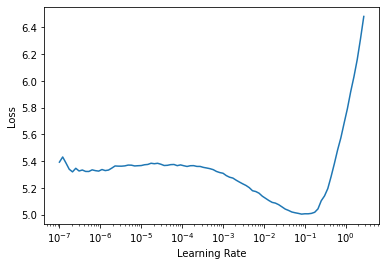

In [56]:
learn.lr_find()

In [57]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.358278,4.255285,0.290644,70.476883,02:52


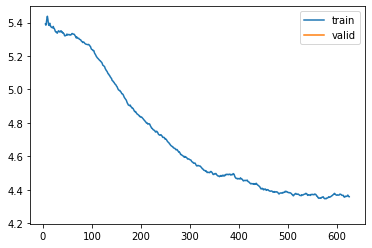

In [58]:
learn.recorder.plot_loss()

In [59]:
learn.save(path/'models/1epoch_movie_fr')

Path('/content/allocine/models/1epoch_movie_fr.pth')

In [60]:
# model size
!du -hs {path}/'models/1epoch_movie_fr.pth'

520M	/content/allocine/models/1epoch_movie_fr.pth


### Fine Tuning

In [61]:
learn.load(path/'models/1epoch_movie_fr')

 Freeze all layers but the last 2 layers groups

In [62]:
learn.freeze_to(-2)
learn.summary()

GPT2LMHeadModel (Input shape: 8)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 256 x 768       
Embedding                                 47041536   False     
Embedding                                 786432     False     
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     8 x 256 x 2304      
Conv1D                                    1771776    False     
Conv1D                                    590592     False     
Dropout                                                        
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     8 x 256 x 3072      
Conv1D                                    23623

In [63]:
learn.fit_one_cycle(1, slice(1e-4/(2.6**4),1e-4))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.299450,4.178769,0.295117,65.285416,02:52


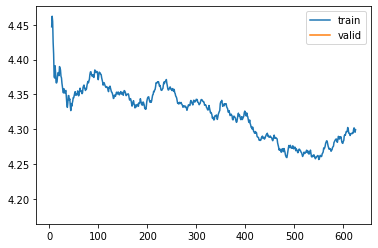

In [64]:
learn.recorder.plot_loss()

In [65]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-4/(2.6**4),1e-4))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.604341,3.513778,0.351191,33.574883,03:39


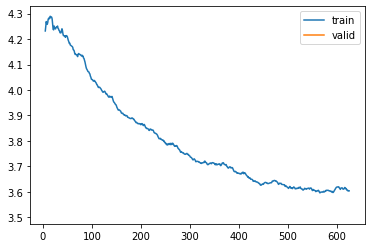

In [66]:
learn.recorder.plot_loss()

Unfreeze All Layers

In [67]:
learn.unfreeze()
learn.summary()

GPT2LMHeadModel (Input shape: 8)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 256 x 768       
Embedding                                 47041536   True      
Embedding                                 786432     True      
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     8 x 256 x 2304      
Conv1D                                    1771776    True      
Conv1D                                    590592     True      
Dropout                                                        
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     8 x 256 x 3072      
Conv1D                                    23623

In [68]:
learn.fit_one_cycle(2, slice(1e-4/(2.6**4),1e-4))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.494012,3.435922,0.359950,31.060041,04:00
1,3.419339,3.412811,0.362637,30.350441,04:00


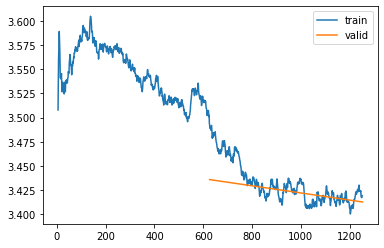

In [69]:
learn.recorder.plot_loss()

### Saving model

In [70]:
learn.save(path/'models/finetuned_movie_fr')

Path('/content/allocine/models/finetuned_movie_fr.pth')

In [71]:
# model size
!du -hs {path}/'models/finetuned_movie_fr.pth'

1.5G	/content/allocine/models/finetuned_movie_fr.pth


In [72]:
# !cp {path}/models/finetuned_movie_fr.pth /content/drive/MyDrive

cp: cannot create regular file '/content/drive/MyDrive': No such file or directory


## Saving the fined-tune vocab

In [74]:
# saving the vocab into a file
textfile = open("/content/allocine/data/vocab_lm.txt", "w")
for element in tokenizer_fastai_vocab_ls_fr:
    textfile.write(element + "\n")
textfile.close()

In [75]:
# reading the vocab_lm file
textfile = open("/content/allocine/data/vocab_lm.txt", "r")
line = 5
for item in range(line):
    x = textfile.readline()
    print(x, end="")
textfile.close()

<s>
<pad>
</s>
!
"


In [76]:
path

Path('/content/allocine')

In [77]:
vocab_fine_tuned = tokenizer.save_vocabulary(path/"data", 'vocab_lm1')

## Inference

In [78]:
path='/content/allocine/'

In [79]:
df_valid.head(1)

,0,1,2
0,http://www.allocine.fr/film/fichefilm-51895/critiques/spectateurs,"Ce film est tout ce qu'il y a de plus sympa. Même si l'ensemble n'est pas dépourvu de clichés, il serait hypocrite de dire que ce film est ennuyeux à regarder, bien au contraire. Il est très plaisant à regarder et même si l'ensemble est asse convenue, la mise en scène de Peter Chelsom est légère et ce film est une sorte de bouffée d'air frais. Tout à fait estimable.",0


In [80]:
#prompt = "Robert de Niro est un excellent acteur et "
prompt = "Ce film est vraiment marrant, Louis de Funes incarne"

In [81]:
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
#inp = tensor(prompt_ids)[None]
inp.shape

torch.Size([1, 11])

In [82]:
preds = learn.model.generate(inp, max_length=40, num_beams=5, temperature=1.5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


NOTE:  Beam search is a popular search strategy for the sequence to sequence Deep NLP algorithms. It will consider ,multiple alternatives compare to greedy search that will only pickup one most likely word and move on. [beam search algorithm](https://www.youtube.com/watch?v=RLWuzLLSIgw)

`temperature` is a hyperparameter used to control the randomness of predictions by scaling the logits before applying softmax.


In [83]:
tokenizer.decode(preds[0].cpu().numpy())

'Ce film est vraiment marrant, Louis de Funes incarne très bien l’amour et l’héroïne, c’est un très bon film d�'

NOTE: You can also generate multiple texts at a time by specifing `nsamples`. Unique to GPT-2, you can pass a `batch_size` to generate multiple samples in parallel, giving a massive speedup (in Colaboratory, set a maximum of 20 for batch_size).

Other optional-but-helpful parameters for gpt2.generate and friends:

- `length`: Number of tokens to generate (default 1023, the maximum)
- `temperature`: The higher the temperature, the crazier the text (default 0.7, recommended to keep between 0.7 and 1.0)
- `top_k`: Limits the generated guesses to the top k guesses (default 0 which disables the behavior; if the generated output is super crazy, you may want to set top_k=40)
- `top_p`: Nucleus sampling: limits the generated guesses to a cumulative probability. (gets good results on a dataset with top_p=0.9)
- `truncate`: Truncates the input text until a given sequence, excluding that sequence (e.g. if truncate='<|endoftext|>', the returned text will include everything before the first <|endoftext|>). It may be useful to combine this with a smaller length if the input texts are short.
- `include_prefix`: If using truncate and include_prefix=False, the specified prefix will not be included in the returned text.

## Top_k

`top_k`: Limits the generated guesses to the top k guesses (default 0 which disables the behavior; if the generated output is super crazy, you may want to set top_k=40)

In [84]:
#prompt = "L'histoire, somme toute banale des déçus de l'amour que sont de M Chow et Mme Chan a cela d'universelle qu'elle peut arriver à tout le monde. Le génie de Wong Kar Wai est d'avoir transcendé le genre des comédies dramatiques"
#prompt = "Le petit Gérard aime passer du temps avec son oncle, M. Hulot, un personnage rêveur et bohème qui "
prompt = "Un petit photographe part à la recherche d'un scoop à travers New York pour devenir reporter."
prompt = "Dans le Japon du XVIe siècle, le seigneur Hidetora Ichimonji décide "
print(prompt)

Dans le Japon du XVIe siècle, le seigneur Hidetora Ichimonji décide 


In [85]:
# encode
input_ids = tokenizer.encode(prompt, return_tensors='pt').to('cuda')

In [86]:
max_length = tokenizer.model_max_length=1024

In [88]:
sample_outputs = model.generate(input_ids, pad_token_id=50256,
                                   do_sample=True, 
                                   max_length=max_length, 
                                   min_length=max_length,
                                   top_k=40,
                                   num_return_sequences=3)

for i, sample_output in enumerate(sample_outputs):
    print(">> Generated text {}\n\n{}".format(i+1, tokenizer.decode(sample_output.tolist())))
    print('\n---')

>> Generated text 1

Dans le Japon du XVIe siècle, le seigneur Hidetora Ichimonji décide ˀétablir une nouvelle religionˀen l’individualisant en divinité hindoue. Dans la société japonaise de l'époque, la religion n'est plus définie qu'avec l’existence de la vie sur terre, mais se trouve en dehors du pouvoir de la nature, comme chez les peuples occidentaux. C’est également en ce sens que la conscience de ce dernier dépasse celle des hommes et de la nature. Dans le Japon féodal comme aujourd'hui, l’absence de culture est l’absence de la loi du plus fort. Et là, la puissance de l’étoile n’est plus un obstacle, mais un catalyseur! Il serait peut-être temps que ces mentalités changent. Le Japon féodal au milieu des années 1960 se trouve être une sorte d’autre nature. Le problème, pour la majorité des Japonais d’ailleurs, est qu’elles ne sont pas conscientes de ce que les Japonais peuvent subir en matière d’informatiques et de technologie (du moins pas en anglais mais en japonais) ; si les p

# Model Sharing and Uploading on the Huggingface platform

Once your model has been pretrained, you can share it on the Huggingface Models Hub by following these [steps](https://huggingface.co/transformers/model_sharing.html)

# Reading
- [Attention is all you need](https://arxiv.org/abs/1706.03762)
- [The illustrated transformer](https://jalammar.github.io/illustrated-transformer/)
-[Openai Better Language Models](https://openai.com/blog/better-language-models/)

# Attributions



```
@misc{louis2020belgpt2,
  author = {Louis, Antoine},
  title = {{BelGPT-2: a GPT-2 model pre-trained on French corpora.}},
  year = {2020},
  howpublished = {\url{https://github.com/antoiloui/belgpt2}},
}
```





```
Théophile Blard, French sentiment analysis with BERT, (2020), 
[GitHub repository,](https://github.com/TheophileBlard/french-sentiment-analysis-with-bert)

